In [0]:
# !pip install --upgrade tensorflow-gpu==1.14.0

In [0]:
# GPU test
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ls -al

total 2807
drwx------ 4 root root    4096 Sep 30 08:18  AugmentedDataset/
drwx------ 2 root root    4096 Apr 15 07:18 'Colab Notebooks'/
-rw------- 1 root root 1428937 Oct  1 11:26 'Copy of UberCab_Dec2008.pdf'
drwx------ 2 root root    4096 Feb 23  2019  JokeFactory/
drwx------ 2 root root    4096 Feb 23  2019  Life/
-rw------- 1 root root 1428937 Jun 22 16:22  UberCab_Dec2008.pdf


In [0]:
cd drive/My\ Drive/

/content/drive/My Drive


# Main Part

In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


##Define augmentation data generator

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

In [0]:
TrainGen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True)

MaskGen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True)

In [0]:
MySeed = 1

In [0]:
image_generator = TrainGen.flow_from_directory(
    '/content/drive/My Drive/AugmentedDataset/images/',
    target_size=(128,128),
    class_mode=None,
    seed=MySeed)

mask_generator = MaskGen.flow_from_directory(
    '/content/drive/My Drive/AugmentedDataset/masks/',
    target_size=(128,128),
    color_mode = 'grayscale',
    class_mode=None,
    seed=MySeed)

Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.


In [0]:
train_generator = zip(image_generator, mask_generator)

## Build and train neural network

In [0]:
# Build U-Net model
inputs = Input((128, 128, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 128, 128, 16) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 

In [0]:
# Fit model
results = model.fit_generator(train_generator, steps_per_epoch=10, epochs=50)

Epoch 1/50
10/10 [==============================] - 7s 707ms/step - loss: -255.6824
Epoch 2/50
10/10 [==============================] - 2s 162ms/step - loss: -506.1299
Epoch 3/50
10/10 [==============================] - 3s 270ms/step - loss: -506.1168
Epoch 4/50
10/10 [==============================] - 3s 270ms/step - loss: -506.1165
Epoch 5/50
10/10 [==============================] - 3s 274ms/step - loss: -506.1163
Epoch 6/50
10/10 [==============================] - 3s 268ms/step - loss: -506.1164
Epoch 7/50
10/10 [==============================] - 3s 271ms/step - loss: -506.1164
Epoch 8/50
10/10 [==============================] - 3s 272ms/step - loss: -506.1163
Epoch 9/50
10/10 [==============================] - 3s 268ms/step - loss: -506.1164
Epoch 10/50
10/10 [==============================] - 3s 270ms/step - loss: -506.1163
Epoch 11/50
10/10 [==============================] - 3s 268ms/step - loss: -506.1163
Epoch 12/50
10/10 [==============================] - 3s 269ms/step - loss:

##Make predictions


In [0]:
train = next(image_generator)

In [0]:
train.dtype

dtype('uint8')

In [0]:
train = train.astype(np.uint8)

In [0]:
train.dtype

dtype('uint8')

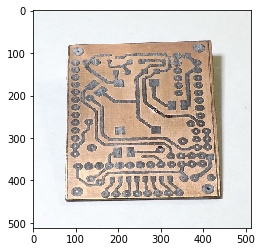

In [0]:
plt.imshow(train[2])

In [0]:
predicted = model.predict(np.expand_dims(train[2], axis=0))

In [0]:
set(np.squeeze(predicted).flat)

{1.0}

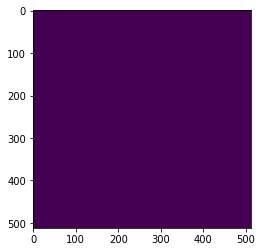

In [0]:
plt.imshow(np.squeeze(predicted))